In [2]:
import numpy as np 
import astropy.constants as c
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import gc
import math
#list all the constants used
G=c.G.value
M_sun=c.M_sun.value
M_earth=c.M_earth.value
R_sun=c.R_sun.value
R_earth=c.R_earth.value
hour=3600 #s
day=3600*24
e=0.1
t_LC=1765.5 #s

def delta(Rp, Rs):
    delta = (Rp*R_earth / (Rs*R_sun))**2*1e6
    return delta

def SNR(delta,n,sigma_s):
    SNR=delta*n**0.5/sigma_s
    return SNR

def sigma_s(t, sigma_LC, cdppindex): #t/hour
    t_LC=1765.5/hour 

    return sigma_LC*(t/t_LC)**cdppindex

def t_dur(P,Rs,e,a): #hour
    t_dur = P*day*Rs*R_sun*(1-e**2)/(np.pi*a)/hour
    return t_dur

def a(Ms,P):
    a=((G*Ms*M_sun*(P*day)**2)/(4*np.pi**2))**(1/3)
    return a 

def n(t_obs,P): # the unite of t_obs and P is day
    n=t_obs/P
    return n

def f_n(t_obs,P):
    if t_obs <=2*P:
        return 0
    if t_obs> 2*P and t_obs< 3*P:
        return (t_obs/P-2)
    if t_obs>=3*P:
        return 1
    
def f_eff(SNR):
    if SNR <=6:
        return 0
    if SNR >6 and SNR<=12:
        return (SNR-6)/6
    if SNR>12:
        return 1
    
def f_geo(Rp,Rs,a,e):
    f_geo = (Rp*R_earth+Rs*R_sun)/(a*(1-e**2))
    return f_geo


/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dyz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/dyz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


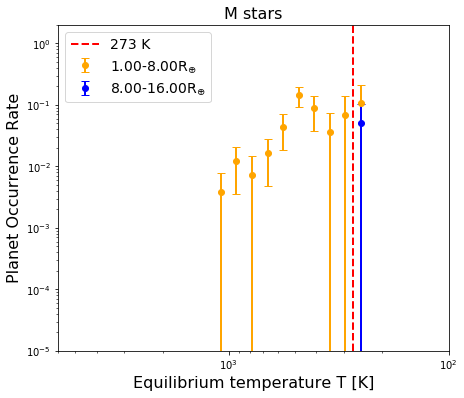

In [15]:
#M type star
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_stellar_q17_add_dispersions_reduction_reduction_M.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_koi_q17_add_dispersions_reduction_reduction_M_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/result/occurrence_rate_M_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
#bins_radius_new=[1,2,4,8,16]
bins_radius_new=[1,8,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
fig=plt.figure(figsize=(7,6))
for k in range(0,2):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    t_temp=[]
    t=[]
    t_std=[]
    for i in range(0,len(bins_t)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if teff_planet[f_id[j]]<bins_t[i+1] and teff_planet[f_id[j]]>=bins_t[i] and koi_table['koi_period'][f_id[j]]<250 and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE'\
            and koi_table['koi_prad'][f_id[j]]<=bins_radius_new[k+1] and koi_table['koi_prad'][f_id[j]]>=bins_radius_new[k]:     
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                t_temp.append(teff_planet[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        t.append((bins_t[i+1]+bins_t[i])/2)
        t_std.append(np.std(t_temp))

        
    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color=colors[k],elinewidth=2,capsize=4,label='{:.2f}'.format(bins_radius_new[k])+'-'+'{:.2f}'.format(bins_radius_new[k+1])+'R$_{\oplus}$')

#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Equilibrium temperature T [K]', fontsize=16)
plt.ylabel('Planet Occurrence Rate',fontsize=16,)
plt.xlim(6000,100)
plt.ylim(1e-5,2)
x=[273]*1000
y=np.linspace(1e-5,2,1000)
plt.plot(x,y,'r--',linewidth=2,label='273 K')
plt.legend(loc='best',fontsize=14)
#plt.savefig('result/focc_rp_tot_2020.png',dpi=300)
plt.title('M stars',fontsize=16)
#plt.savefig('result/focc_temperature_M_2020_p_r1-16_newbin_no_false-positive.png',dpi=300)
plt.savefig('result/focc_temperature_M_2020_p<250_r1-16_newbin_no_false-positive.png',dpi=300)

/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


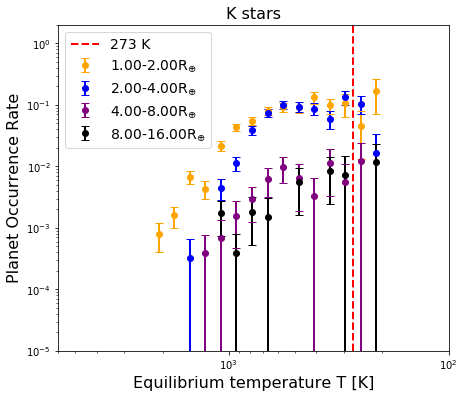

In [16]:
#K type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_stellar_q17_add_dispersions_reduction_reduction_K.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/result/occurrence_rate_K_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,2,4,8,16]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
fig=plt.figure(figsize=(7,6))
for k in range(0,4):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    t_temp=[]
    t=[]
    t_std=[]
    for i in range(0,len(bins_t)-1):
        focc_temp=[]
        p_temp=[]
        #and koi_table['koi_period'][f_id[j]]<=356
        for j in range(0,len(f_occurrence_everyplanet)):
            if teff_planet[f_id[j]]<bins_t[i+1] and teff_planet[f_id[j]]>=bins_t[i] and koi_table['koi_period'][f_id[j]]<250 and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE'\
            and koi_table['koi_prad'][f_id[j]]<=bins_radius_new[k+1] and koi_table['koi_prad'][f_id[j]]>=bins_radius_new[k]:     
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                t_temp.append(teff_planet[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        t.append((bins_t[i+1]+bins_t[i])/2)
        t_std.append(np.std(t_temp))

        
    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color=colors[k],elinewidth=2,capsize=4,label='{:.2f}'.format(bins_radius_new[k])+'-'+'{:.2f}'.format(bins_radius_new[k+1])+'R$_{\oplus}$')

#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Equilibrium temperature T [K]', fontsize=16)
plt.ylabel('Planet Occurrence Rate',fontsize=16,)
plt.xlim(6000,100)
plt.ylim(1e-5,2)
x=[273]*1000
y=np.linspace(1e-5,2,1000)
plt.plot(x,y,'r--',linewidth=2,label='273 K')
plt.legend(loc='best',fontsize=14)
#plt.savefig('result/focc_rp_tot_2020.png',dpi=300)
plt.title('K stars',fontsize=16)
#plt.savefig('result/focc_temperature_K_2020_p_r1-16_newbin_no_false-positive.png',dpi=300)
plt.savefig('result/focc_temperature_K_2020_p<250_r1-16_newbin_no_false-positive.png',dpi=300)

In [11]:
#F type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/result/occurrence_rate_F_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4,16]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)



/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


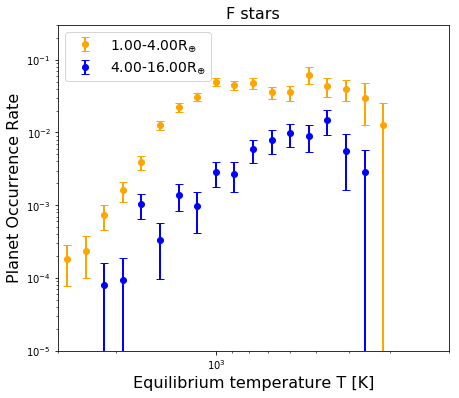

In [38]:
#F type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')

bins_t=np.logspace(math.log(200,2),math.log(3000,2),22,base=2)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/result/occurrence_rate_F_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4,16]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue']
fig=plt.figure(figsize=(7,6))
for k in range(0,2):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    t_temp=[]
    t=[]
    t_std=[]
    for i in range(0,len(bins_t)-1):
        focc_temp=[]
        p_temp=[]
        #and koi_table['koi_period'][f_id[j]]<=356\
        for j in range(0,len(f_occurrence_everyplanet)):
            if teff_planet[f_id[j]]<bins_t[i+1] and teff_planet[f_id[j]]>=bins_t[i] and koi_table['koi_period'][f_id[j]]<250 and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE'\
            and koi_table['koi_prad'][f_id[j]]<=bins_radius_new[k+1] and koi_table['koi_prad'][f_id[j]]>=bins_radius_new[k]:     
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                t_temp.append(teff_planet[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        t.append((bins_t[i+1]+bins_t[i])/2)
        t_std.append(np.std(t_temp))

        
    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color=colors[k],elinewidth=2,capsize=4,label='{:.2f}'.format(bins_radius_new[k])+'-'+'{:.2f}'.format(bins_radius_new[k+1])+'R$_{\oplus}$')

#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Equilibrium temperature T [K]', fontsize=16)
plt.ylabel('Planet Occurrence Rate',fontsize=16,)
plt.xlim(3000,200)
plt.ylim(1e-5,3e-1)
x=[273]*1000
y=np.linspace(1e-5,3e-1,1000)
#plt.plot(x,y,'r--',linewidth=2,label='273 K')
plt.legend(loc='best',fontsize=14)
#plt.savefig('result/focc_rp_tot_2020.png',dpi=300)
plt.title('F stars',fontsize=16)
#plt.savefig('result/focc_temperature_G_2020_p_r1-16_no_false-positive.png.png',dpi=300)
plt.savefig('result/focc_temperature_F_2020_p<356_r1-16_newbin_no_false-positive.png',dpi=300)

In [34]:
max(koi_table['koi_period'])

1064.2680956

/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


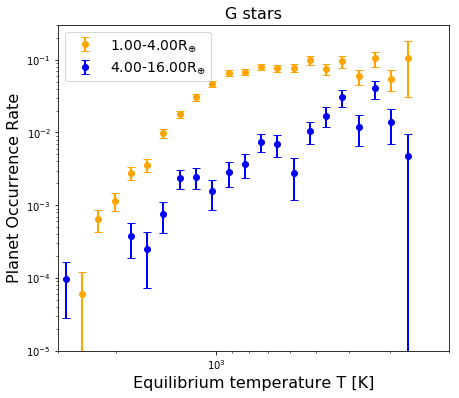

In [37]:
#G type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G_new.csv',sep=',')

bins_t=np.logspace(math.log(200,5),math.log(3000,5),25,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/result/occurrence_rate_G_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4,16]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
fig=plt.figure(figsize=(7,6))
for k in range(0,2):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    t_temp=[]
    t=[]
    t_std=[]
    for i in range(0,len(bins_t)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            #and koi_table['koi_period'][f_id[j]]<=356
            if teff_planet[f_id[j]]<bins_t[i+1] and teff_planet[f_id[j]]>=bins_t[i] and koi_table['koi_period'][f_id[j]]<365 and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE'\
            and koi_table['koi_prad'][f_id[j]]<=bins_radius_new[k+1] and koi_table['koi_prad'][f_id[j]]>=bins_radius_new[k]:     
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                t_temp.append(teff_planet[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        t.append((bins_t[i+1]+bins_t[i])/2)
        t_std.append(np.std(t_temp))

        
    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color=colors[k],elinewidth=2,capsize=4,label='{:.2f}'.format(bins_radius_new[k])+'-'+'{:.2f}'.format(bins_radius_new[k+1])+'R$_{\oplus}$')

#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Equilibrium temperature T [K]', fontsize=16)
plt.ylabel('Planet Occurrence Rate',fontsize=16,)
plt.xlim(3000,200)
plt.ylim(1e-5,3e-1)
x=[273]*1000
y=np.linspace(1e-5,3e-1,1000)
#plt.plot(x,y,'r--',linewidth=2,label='273 K')
plt.legend(loc='best',fontsize=14)
#plt.savefig('result/focc_rp_tot_2020.png',dpi=300)
plt.title('G stars',fontsize=16)
#plt.savefig('result/focc_temperature_G_2020_p_r1-16_no_false-positive.png.png',dpi=300)
plt.savefig('result/focc_temperature_G_2020_p<356_r1-16_newbin_no_false-positive.png',dpi=300)

/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:145: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in double_scalars


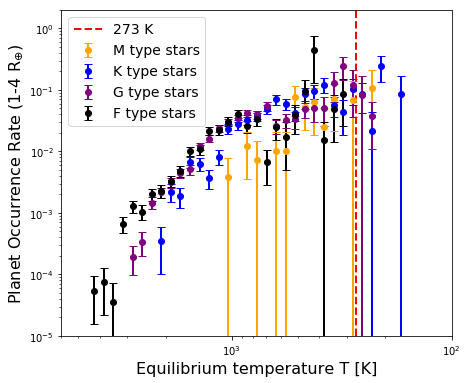

In [66]:
#M type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_stellar_q17_add_dispersions_reduction_reduction_M.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_koi_q17_add_dispersions_reduction_reduction_M.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),40,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/result/occurrence_rate_M_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
#bins_radius_new=[1,2,4,8,16]
bins_radius_new=[1,2]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    t_temp=[]
    t=[]
    t_std=[]
    for i in range(0,len(bins_t)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if teff_planet[f_id[j]]<bins_t[i+1] and teff_planet[f_id[j]]>=bins_t[i] and koi_table['koi_period'][f_id[j]]<=356\
            and koi_table['koi_prad'][f_id[j]]<=bins_radius_new[k+1] and koi_table['koi_prad'][f_id[j]]>=bins_radius_new[k]:     
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                t_temp.append(teff_planet[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        t.append((bins_t[i+1]+bins_t[i])/2)
        t_std.append(np.std(t_temp))

        
    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')


#K type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_stellar_q17_add_dispersions_reduction_reduction_K.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),40,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/result/occurrence_rate_K_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,2]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    t_temp=[]
    t=[]
    t_std=[]
    for i in range(0,len(bins_t)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if teff_planet[f_id[j]]<bins_t[i+1] and teff_planet[f_id[j]]>=bins_t[i] and koi_table['koi_period'][f_id[j]]<=356\
            and koi_table['koi_prad'][f_id[j]]<=bins_radius_new[k+1] and koi_table['koi_prad'][f_id[j]]>=bins_radius_new[k]:     
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                t_temp.append(teff_planet[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        t.append((bins_t[i+1]+bins_t[i])/2)
        t_std.append(np.std(t_temp))

        
    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')

    
#G type stars    
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),40,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/result/occurrence_rate_G_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,2]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    t_temp=[]
    t=[]
    t_std=[]
    for i in range(0,len(bins_t)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if teff_planet[f_id[j]]<bins_t[i+1] and teff_planet[f_id[j]]>=bins_t[i] and koi_table['koi_period'][f_id[j]]<=356\
            and koi_table['koi_prad'][f_id[j]]<=bins_radius_new[k+1] and koi_table['koi_prad'][f_id[j]]>=bins_radius_new[k]:     
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                t_temp.append(teff_planet[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        t.append((bins_t[i+1]+bins_t[i])/2)
        t_std.append(np.std(t_temp))

        
    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars')

#F type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),40,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/result/occurrence_rate_F_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,2]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    t_temp=[]
    t=[]
    t_std=[]
    for i in range(0,len(bins_t)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if teff_planet[f_id[j]]<bins_t[i+1] and teff_planet[f_id[j]]>=bins_t[i] and koi_table['koi_period'][f_id[j]]<=356\
            and koi_table['koi_prad'][f_id[j]]<=bins_radius_new[k+1] and koi_table['koi_prad'][f_id[j]]>=bins_radius_new[k]:     
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                t_temp.append(teff_planet[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        t.append((bins_t[i+1]+bins_t[i])/2)
        t_std.append(np.std(t_temp))

        
    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='F type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='F type stars')
    
#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Equilibrium temperature T [K]', fontsize=16)
plt.ylabel('Planet Occurrence Rate (1-4 R$_{\oplus}$)',fontsize=16,)
plt.xlim(6000,100)
plt.ylim(1e-5,2)
x=[273]*1000
y=np.linspace(1e-5,2,1000)
plt.plot(x,y,'r--',linewidth=2,label='273 K')
plt.legend(loc='best',fontsize=14)
#plt.savefig('result/focc_rp_tot_2020.png',dpi=300)
#plt.title('M stars',fontsize=16)
plt.savefig('result/focc_temperature_FGKM_2020_p<365_r1-2_newbin.png',dpi=300)
#plt.savefig('result/focc_p_FGKM_2020_p<250_r1-4_newbin.png',dpi=300)


/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


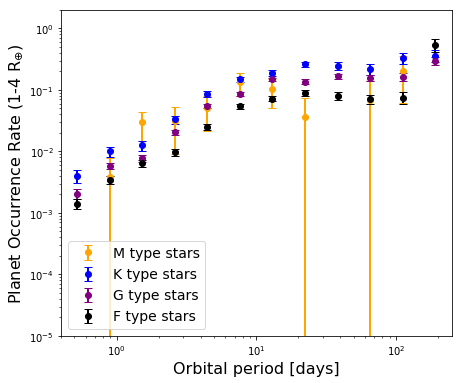

In [30]:
#M type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_stellar_q17_add_dispersions_reduction_reduction_M.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_koi_q17_add_dispersions_reduction_reduction_M.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/result/occurrence_rate_M_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
#bins_radius_new=[1,2,4,8,16]
bins_radius_new=[1,4]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')


#K type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_stellar_q17_add_dispersions_reduction_reduction_K.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/result/occurrence_rate_K_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')

    
#G type stars    
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/result/occurrence_rate_G_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars')

#F type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/result/occurrence_rate_F_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:

                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='F type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='F type stars')
    
#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Orbital period [days]', fontsize=16)
plt.ylabel('Planet Occurrence Rate (1-4 R$_{\oplus}$)',fontsize=16,)
plt.xlim(0.4,250)
plt.ylim(1e-5,2)
#x=[273]*1000
y=np.linspace(1e-5,2,1000)
#plt.plot(x,y,'r--',linewidth=2,label='273 K')
plt.legend(loc='best',fontsize=14)
#plt.savefig('result/focc_rp_tot_2020.png',dpi=300)
#plt.title('M stars',fontsize=16)
#plt.savefig('result/focc_temperature_FGKM_2020_p<250_r1-4_newbin.png',dpi=300)
plt.savefig('result/focc_p_FGKM_2020_p<250_r1-4_newbin.png',dpi=300)

/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in double_scalars


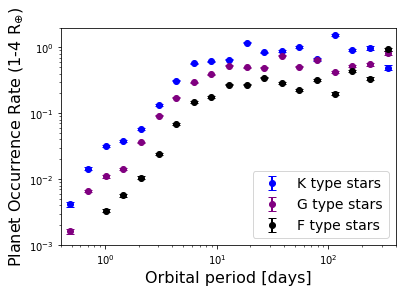

In [18]:
#P<365day 1-4Rearth focc 等间隔取bin x_axis P
#K type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_stellar_q17_add_dispersions_reduction_reduction_K.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,10),math.log(400,10),20,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/result/occurrence_rate_K_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp)/np.log10(bins_period[i+1]/bins_period[i]))   
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append((bins_period[i+1]+bins_period[i])/2)
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')

    
#G type stars    
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,10),math.log(400,10),20,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/result/occurrence_rate_G_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE'\
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp)/np.log10(bins_period[i+1]/bins_period[i]))   
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append((bins_period[i+1]+bins_period[i])/2)
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars')

#F type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,10),math.log(400,10),20,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/result/occurrence_rate_F_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE'\
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:

                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp)/np.log10(bins_period[i+1]/bins_period[i]))   
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append((bins_period[i+1]+bins_period[i])/2)
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='F type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='F type stars')
    
#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Orbital period [days]', fontsize=16)
plt.ylabel('Planet Occurrence Rate (1-4 R$_{\oplus}$)',fontsize=16,)
plt.xlim(0.4,400)
plt.ylim(1e-3,2)
#x=[273]*1000
y=np.linspace(1e-5,2,1000)
#plt.plot(x,y,'r--',linewidth=2,label='273 K')
plt.legend(loc='best',fontsize=14)
#plt.savefig('result/focc_rp_tot_2020.png',dpi=300)
#plt.title('M stars',fontsize=16)
#plt.savefig('result/focc_temperature_FGKM_2020_p<250_r1-4_newbin.png',dpi=300)
#plt.savefig('result/focc_a_FGKM_2020_p_no_false_positive_r1-4_newbin.png',dpi=300)
plt.savefig('result/p_FGK_1_4Rearth_p_365_interval.eps',dpi=300)



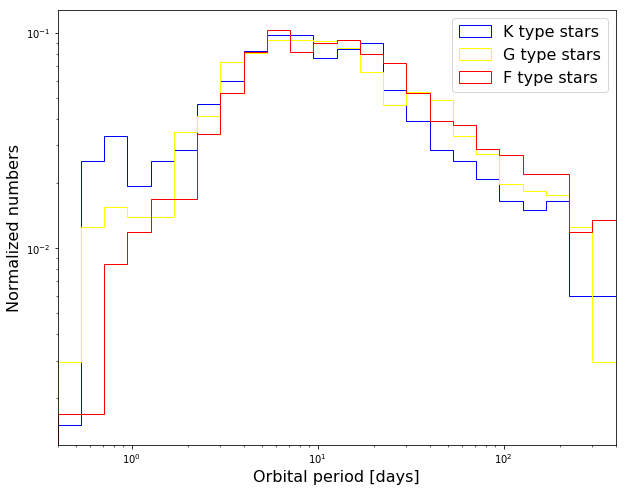

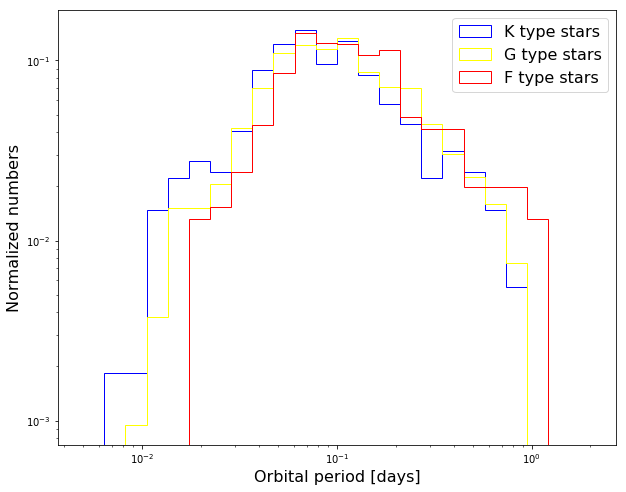

In [23]:
#P<365day 1-4Rearth focc 等间隔取bin x_axis P
#K type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_stellar_q17_add_dispersions_reduction_reduction_K.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),25,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)




fig=plt.figure(figsize=(10,8))

koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K_new.csv',sep=',')
p_temp1=[]
for i in range(0,len(koi_table)):
    if koi_table['koi_disposition'][i]!='FALSE POSITIVE' and koi_table['koi_period'][i]<=365:
    #and koi_table['koi_prad'][i]<=4 and koi_table['koi_prad'][i]>=1 
        p_temp1.append(koi_table['koi_period'][i])
        
weights1 = np.ones_like(p_temp1)/float(len(p_temp1))    
plt.hist(p_temp1,bins_period,histtype="step",weights=weights1,color='blue',label='K type stars')    


koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G_new.csv',sep=',')
p_temp2=[]
for i in range(0,len(koi_table)):
    if koi_table['koi_disposition'][i]!='FALSE POSITIVE' and koi_table['koi_period'][i]<=365:
    #and koi_table['koi_prad'][i]<=4 and koi_table['koi_prad'][i]>=1 and koi_table['koi_period'][i]<=365:
        p_temp2.append(koi_table['koi_period'][i])
        
weights1 = np.ones_like(p_temp2)/float(len(p_temp2))    
plt.hist(p_temp2,bins_period,histtype="step",weights=weights1,color='yellow',label='G type stars')


koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')
p_temp3=[]
for i in range(0,len(koi_table)):
    if koi_table['koi_disposition'][i]!='FALSE POSITIVE' and koi_table['koi_period'][i]<=365:
    #and koi_table['koi_prad'][i]<=4 and koi_table['koi_prad'][i]>=1 and koi_table['koi_period'][i]<=365:
        p_temp3.append(koi_table['koi_period'][i])
        
weights1 = np.ones_like(p_temp3)/float(len(p_temp3))    
plt.hist(p_temp3,bins_period,histtype="step",weights=weights1,color='red',label='F type stars')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Orbital period [days]', fontsize=16)
plt.ylabel('Normalized numbers',fontsize=16,)
plt.xlim(0.4,400)
plt.legend(loc='best',fontsize=16)
plt.show()


bins_period=np.logspace(math.log(0.005,10),math.log(2,10),25,base=10)
fig=plt.figure(figsize=(10,8))
############################################################3
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K_new.csv',sep=',')
a_koi=[]
for i in range(0,len(koi_table)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)
    
a_temp=[]
for i in range(0,len(koi_table)):
    if koi_table['koi_disposition'][i]!='FALSE POSITIVE' and koi_table['koi_period'][i]<=365 \
    and koi_table['koi_prad'][i]<=4 and koi_table['koi_prad'][i]>=1 :
        a_temp.append(a_koi[i])
        
weights1 = np.ones_like(a_temp)/float(len(a_temp))    
plt.hist(a_temp,bins_period,histtype="step",weights=weights1,color='blue',label='K type stars')    

#########################################################
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G_new.csv',sep=',')
a_koi=[]
for i in range(0,len(koi_table)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)
    
a_temp=[]
for i in range(0,len(koi_table)):
    if koi_table['koi_disposition'][i]!='FALSE POSITIVE' and koi_table['koi_period'][i]<=365 \
    and koi_table['koi_prad'][i]<=4 and koi_table['koi_prad'][i]>=1 :
        a_temp.append(a_koi[i])
        
weights1 = np.ones_like(a_temp)/float(len(a_temp))  
plt.hist(a_temp,bins_period,histtype="step",weights=weights1,color='yellow',label='G type stars')

############################################################3
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')
a_koi=[]
for i in range(0,len(koi_table)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)
    
a_temp=[]
for i in range(0,len(koi_table)):
    if koi_table['koi_disposition'][i]!='FALSE POSITIVE' and koi_table['koi_period'][i]<=365 \
    and koi_table['koi_prad'][i]<=4 and koi_table['koi_prad'][i]>=1 :
        a_temp.append(a_koi[i])
        
weights1 = np.ones_like(a_temp)/float(len(a_temp))  
plt.hist(a_temp,bins_period,histtype="step",weights=weights1,color='red',label='F type stars')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Orbital period [days]', fontsize=16)
plt.ylabel('Normalized numbers',fontsize=16,)

plt.legend(loc='best',fontsize=16)
plt.show()


In [2]:
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')

period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
        
#print(period,len(period))

number=23
interval=20
bins_period=[]
period.sort()
print(max(period),min(period),len(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)


364.98242 0.876850385 455
[0.876850385, 0.929906166, 0.9886684000000001, 0.9916596459999999, 0.998212785, 1.01485981, 1.340596782, 1.4333396040000002, 1.442592305, 1.450889836]
[0.876850385, 2.168451063, 3.39401963, 4.29388808, 5.03728033, 5.83376197, 6.77367892, 7.16520428, 8.18182189, 9.5084871, 10.7781558, 11.87290814, 13.71938426, 15.604841, 17.934660600000004, 20.55331441, 24.3344939, 27.40229859, 32.657035, 46.406259999999996, 66.6434565, 103.42698730000001, 215.634356, 364.98242]


364.75156200000004 0.259819659 541
[0.259819659, 0.34184201700000005, 0.558841234, 0.567856484, 0.571038347, 0.5773693360000001, 0.597018404, 0.626281766, 0.655939788, 0.664074145]
[0.259819659, 0.928310036, 1.615357809, 2.549562652, 3.295701024, 3.97599629, 4.53702121, 4.9213639, 5.715425977000001, 6.30558387, 7.0106324, 7.55842923, 8.34819209, 9.07829171, 10.47548084, 12.03987488, 13.76710058, 16.01308419, 17.60461401, 19.2405821, 21.3684341, 25.1933989, 30.950592699999998, 42.049523793, 53.5783052, 87.0912594, 136.205112, 364.75156200000004]
331.55459 0.352515897 1061
[0.352515897, 0.469334634, 0.49424766200000003, 0.524175803, 0.568874717, 0.609926502, 0.634003002, 0.636424848, 0.665025941, 0.6756504040000001]
[0.352515897, 0.88184263, 1.284241817, 1.897828815, 2.3702932, 2.5903958, 3.00912491, 3.33930957, 3.6093130589999998, 3.92453009, 4.30165843, 4.52628739, 4.8538404, 5.19559398, 5.448321077999999, 5.71462396, 6.05729966, 6.4980147000000015, 6.93365167, 7.2274321, 7.65880048, 8

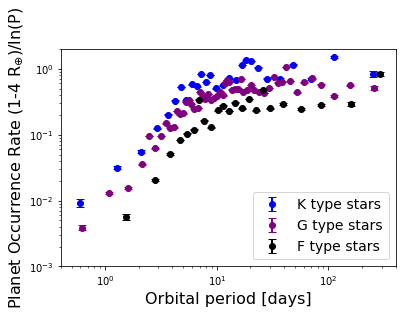

In [15]:
#P<365day 1-4Rearth focc 等数量取bin x_axis P

#需要注意,由于等数量取bin,导致比较时占据的x_axis不一样,这样直接比较数值是没有意义的,此时需要ln归一化
#K type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_stellar_q17_add_dispersions_reduction_reduction_K.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K_new.csv',sep=',')

#bins_period=np.logspace(math.log(0.4,10),math.log(400,10),20,base=10)
period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
        
#print(period,len(period))

number=27
interval=20
bins_period=[]
period.sort()
print(max(period),min(period),len(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)

bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/result/occurrence_rate_K_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
        
        f_p.append(np.sum(focc_temp)/np.log10(bins_period[i+1]/bins_period[i]))   
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append((bins_period[i+1]+bins_period[i])/2)
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')

    
#G type stars    
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G_new.csv',sep=',')

#bins_period=np.logspace(math.log(0.4,10),math.log(400,10),20,base=10)
period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
        
#print(period,len(period))

number=53
interval=20
bins_period=[]
period.sort()
print(max(period),min(period),len(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)

bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/result/occurrence_rate_G_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE'\
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp)/np.log10(bins_period[i+1]/bins_period[i]))   
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append((bins_period[i+1]+bins_period[i])/2)
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars')

#F type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')

#bins_period=np.logspace(math.log(0.4,10),math.log(400,10),20,base=10)
period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
        
#print(period,len(period))

number=23
interval=20
bins_period=[]
period.sort()
print(max(period),min(period),len(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/result/occurrence_rate_F_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE'\
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:

                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp)/np.log10(bins_period[i+1]/bins_period[i]))   
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append((bins_period[i+1]+bins_period[i])/2)
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='F type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='F type stars')
    
#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Orbital period [days]', fontsize=16)
plt.ylabel('Planet Occurrence Rate (1-4 R$_{\oplus}$)/ln(P)',fontsize=16,)
plt.xlim(0.4,400)
plt.ylim(1e-3,2)
#x=[273]*1000
y=np.linspace(1e-5,2,1000)
#plt.plot(x,y,'r--',linewidth=2,label='273 K')
plt.legend(loc='best',fontsize=14)
#plt.savefig('result/focc_rp_tot_2020.png',dpi=300)
#plt.title('M stars',fontsize=16)
#plt.savefig('result/focc_temperature_FGKM_2020_p<250_r1-4_newbin.png',dpi=300)
#plt.savefig('result/focc_a_FGKM_2020_p_no_false_positive_r1-4_newbin.png',dpi=300)
plt.savefig('result/p_FGK_1_4Rearth_p_365_quantity.eps',dpi=300)


In [5]:
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')


a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)

print(min(a_koi),max(a_koi))

0.00801945802507202 1.6516818957882287


/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in double_scalars


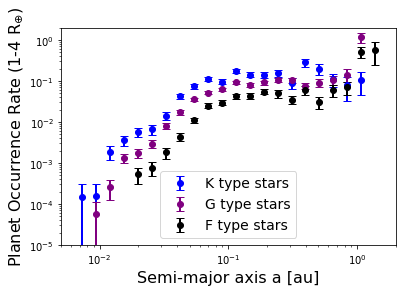

In [16]:
#M type star
'''
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_stellar_q17_add_dispersions_reduction_reduction_M.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_koi_q17_add_dispersions_reduction_reduction_M_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/result/occurrence_rate_M_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
#bins_radius_new=[1,2,4,8,16]
bins_radius_new=[1,4]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')
'''

#K type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_stellar_q17_add_dispersions_reduction_reduction_K.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)



focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/result/occurrence_rate_K_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

    
bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')

    
#G type stars    
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/result/occurrence_rate_G_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='G type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='G type stars')
    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars')
#F type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/result/occurrence_rate_F_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(a_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='F type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='F type stars')

    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='F type stars')    
#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Semi-major axis a [au]', fontsize=16)
plt.ylabel('Planet Occurrence Rate (1-4 R$_{\oplus}$)',fontsize=16,)
plt.xlim(0.005,2)
plt.ylim(1e-5,2)
#x=[273]*1000
y=np.linspace(1e-5,2,1000)
#plt.plot(x,y,'r--',linewidth=2,label='273 K')
plt.legend(loc='best',fontsize=14)
#plt.savefig('result/focc_rp_tot_2020.png',dpi=300)
#plt.title('M stars',fontsize=16)
#plt.savefig('result/focc_temperature_FGKM_2020_p<250_r1-4_newbin.png',dpi=300)
plt.savefig('result/focc_a_FGKM_2020_p_no_false_positive_r1-4_newbin.png',dpi=300)
#plt.savefig('result/focc_p_FGKM_2020_p_no_false_positive_r1-4_newbin.png',dpi=300)

/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in double_scalars


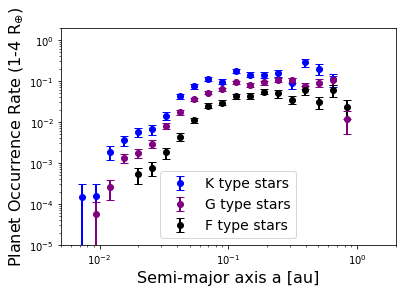

In [15]:
#M type star
'''
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_stellar_q17_add_dispersions_reduction_reduction_M.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_koi_q17_add_dispersions_reduction_reduction_M_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/result/occurrence_rate_M_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
#bins_radius_new=[1,2,4,8,16]
bins_radius_new=[1,4]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')
'''

#K type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_stellar_q17_add_dispersions_reduction_reduction_K.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)



focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/result/occurrence_rate_K_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

    
bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=250 \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')

    
#G type stars    
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/result/occurrence_rate_G_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=250\
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='G type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='G type stars')
    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars')
#F type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/result/occurrence_rate_F_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=250 \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='F type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='F type stars')

    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='F type stars')    
#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Semi-major axis a [au]', fontsize=16)
plt.ylabel('Planet Occurrence Rate (1-4 R$_{\oplus}$)',fontsize=16,)
plt.xlim(0.005,2)
plt.ylim(1e-5,2)
#x=[273]*1000
y=np.linspace(1e-5,2,1000)
#plt.plot(x,y,'r--',linewidth=2,label='273 K')
plt.legend(loc='best',fontsize=14)
#plt.savefig('result/focc_rp_tot_2020.png',dpi=300)
#plt.title('M stars',fontsize=16)
#plt.savefig('result/focc_temperature_FGKM_2020_p<250_r1-4_newbin.png',dpi=300)
plt.savefig('result/focc_a_FGKM_2020_p<250_no_false_positive_r1-4_newbin.png',dpi=300)
#plt.savefig('result/focc_p_FGKM_2020_p_no_false_positive_r1-4_newbin.png',dpi=300)

In [14]:
stellar_table_K=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_stellar_q17_add_dispersions_reduction_reduction_K.csv',sep=',')
koi_table_K=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K_new.csv',sep=',')

stellar_table_G=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table_G=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G_new.csv',sep=',')

stellar_table_F=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')
koi_table_F=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')

mass_K=np.mean(koi_table_K['mass'])
mass_G=np.mean(koi_table_G['mass'])
mass_F=np.mean(koi_table_F['mass'])
print(mass_K,mass_G,mass_F)

print(mass_K/mass_F,mass_G/mass_F)
focck=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/result/occurrence_rate_K_2020.csv')
foccg=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/result/occurrence_rate_G_2020.csv')
foccf=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/result/occurrence_rate_F_2020.csv')

f_k=0
for i in range(0,len(focck['occurrence_rate'])):
    if focck['occurrence_rate'][i]!=np.inf:
        f_k+=focck['occurrence_rate'][i]
        
f_g=0
for i in range(0,len(foccg['occurrence_rate'])):
    if foccg['occurrence_rate'][i]!=np.inf:
        f_g+=foccg['occurrence_rate'][i]
        
f_f=0
for i in range(0,len(foccf['occurrence_rate'])):
    if foccf['occurrence_rate'][i]!=np.inf:
        f_f+=foccf['occurrence_rate'][i]


mass=[mass_K,mass_G,mass_F]
f=[f_k,f_g,f_f]

print(f,mass)

0.7199746416758562 0.9402602676511305 1.1803901791639033
0.6099463163831389 0.7965673420945757
[8.861609276770658, 26.809439319929208, 5.266454370093876] [0.7199746416758562, 0.9402602676511305, 1.1803901791639033]


In [13]:
print(max(focck['occurrence_rate']))

inf


In [5]:
print(mass_K/mass_F,mass_G/mass_F)

0.6171258401369739 0.796147405879408


/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dyz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/dyz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:210: RuntimeWarning: invalid value encountered in double_scalars


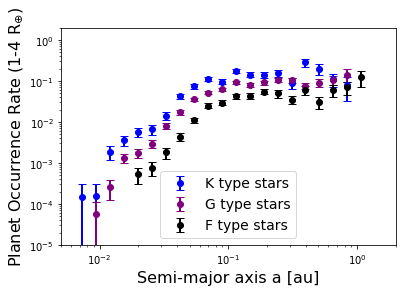

In [33]:
#M type star
'''
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_stellar_q17_add_dispersions_reduction_reduction_M.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_koi_q17_add_dispersions_reduction_reduction_M_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/result/occurrence_rate_M_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
#bins_radius_new=[1,2,4,8,16]
bins_radius_new=[1,4]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')
'''

#K type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_stellar_q17_add_dispersions_reduction_reduction_K.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)



focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/result/occurrence_rate_K_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

    
bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=365 \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')

    
#G type stars    
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/result/occurrence_rate_G_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=365\
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='G type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='G type stars')
    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars')

#F type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/result/occurrence_rate_F_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=365 \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='F type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='F type stars')

    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='F type stars')    
#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Semi-major axis a [au]', fontsize=16)
plt.ylabel('Planet Occurrence Rate (1-4 R$_{\oplus}$)',fontsize=16,)
plt.xlim(0.005,2)
plt.ylim(1e-5,2)
#x=[273]*1000
y=np.linspace(1e-5,2,1000)
#plt.plot(x,y,'r--',linewidth=2,label='273 K')
plt.legend(loc='best',fontsize=14)
#plt.savefig('result/focc_rp_tot_2020.png',dpi=300)
#plt.title('M stars',fontsize=16)
#plt.savefig('result/focc_temperature_FGKM_2020_p<250_r1-4_newbin.png',dpi=300)
plt.savefig('result/focc_a_FGKM_2020_p<365_no_false_positive_r1-4_newbin.png',dpi=300)
#plt.savefig('result/focc_p_FGKM_2020_p_no_false_positive_r1-4_newbin.png',dpi=300)

/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dyz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/dyz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in double_scalars


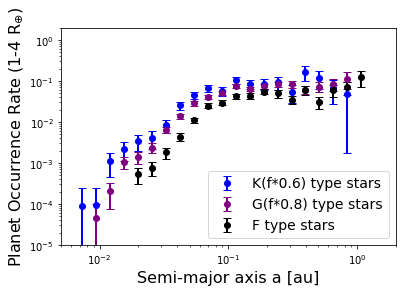

In [6]:
#M type star
'''
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_stellar_q17_add_dispersions_reduction_reduction_M.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_koi_q17_add_dispersions_reduction_reduction_M_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/result/occurrence_rate_M_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
#bins_radius_new=[1,2,4,8,16]
bins_radius_new=[1,4]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')
'''

#K type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_stellar_q17_add_dispersions_reduction_reduction_K.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)



focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/result/occurrence_rate_K_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

    
bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=365 \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp)*0.6)
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K(f*0.6) type stars')

    
#G type stars    
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/result/occurrence_rate_G_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=365\
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp)*0.8)
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='G type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='G type stars')
    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars')
#F type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/result/occurrence_rate_F_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=365 \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='F type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='F type stars')

    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='F type stars')    
#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Semi-major axis a [au]', fontsize=16)
plt.ylabel('Planet Occurrence Rate (1-4 R$_{\oplus}$)',fontsize=16,)
plt.xlim(0.005,2)
plt.ylim(1e-5,2)
#x=[273]*1000
y=np.linspace(1e-5,2,1000)
#plt.plot(x,y,'r--',linewidth=2,label='273 K')
plt.legend(loc='best',fontsize=14)
#plt.savefig('result/focc_rp_tot_2020.png',dpi=300)
#plt.title('M stars',fontsize=16)
#plt.savefig('result/focc_temperature_FGKM_2020_p<250_r1-4_newbin.png',dpi=300)
plt.savefig('result/focc_a_FGKM_2020_p<365_no_false_positive_r1-4_newbin.png',dpi=300)
#plt.savefig('result/focc_p_FGKM_2020_p_no_false_positive_r1-4_newbin.png',dpi=300)

/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:300: RuntimeWarning: invalid value encountered in double_scalars


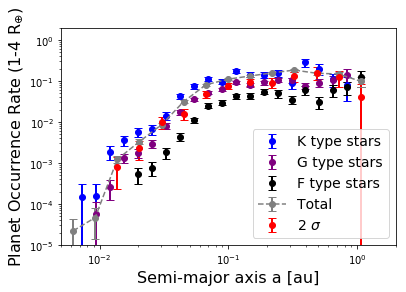

In [38]:
#M type star
'''
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_stellar_q17_add_dispersions_reduction_reduction_M.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/data/kepler_koi_q17_add_dispersions_reduction_reduction_M_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/M/result/occurrence_rate_M_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
#bins_radius_new=[1,2,4,8,16]
bins_radius_new=[1,4]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

colors=['orange','blue','purple','black']
fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    for i in range(0,len(bins_period)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
        p_std.append(np.std(p_temp))

        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')
    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='M type stars')
'''

#K type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_stellar_q17_add_dispersions_reduction_reduction_K.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)



focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/result/occurrence_rate_K_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

    
bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=365 \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')
    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='K type stars')

    
#G type stars    
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/result/occurrence_rate_G_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=365\
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='G type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='G type stars')
    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars')
#F type star

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/result/occurrence_rate_F_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_radius_new=[1,4]
#bins_radius_new=[1,16]
teff_planet=[]
for i in range(0,len(f_occurrence_everyplanet)):
    teff_planet.append(koi_table['teff_b2018'][i]*((koi_table['rad_b2018'][i]*c.R_sun.value)**2/(4*(a(koi_table['mass'][i],koi_table['koi_period'][i]))**2))**0.25)

bins_a=np.logspace(math.log(0.005,2),math.log(2,2),25,base=2)
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)    
    
    
colors=['orange','blue','purple','black']
#fig=plt.figure(figsize=(7,6))
for k in range(0,1):
    f_p=[]
    f_p_std=[]
    p=[]
    p_std=[]
    a_temp=[]
    semi_a=[]
    semi_a_std=[]
    for i in range(0,len(bins_a)-1):
        focc_temp=[]
        p_temp=[]
        for j in range(0,len(f_occurrence_everyplanet)):
            if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=365 \
            and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:
                focc_temp.append(f_occurrence_everyplanet[j])
                p_temp.append(koi_table['koi_period'][f_id[j]])
                a_temp.append(a_koi[f_id[j]])
            
        f_p.append(np.sum(focc_temp))
        f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
#        p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
#        p_std.append(np.std(p_temp))
        semi_a.append((bins_a[i+1]+bins_a[i])/2)
        semi_a_std.append(np.std(p_temp))
        
#    plt.errorbar(t,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='F type stars')
#    plt.errorbar(p,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='F type stars')

    plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='F type stars')    
#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')

#change the Orbital periods to semi-major axis 

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_a=np.logspace(math.log(0.005,2),math.log(1.28,2),15,base=2)
'''
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
tot 
'''
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_1sigma/result/occurrence_tot.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']

colors=['black','k','dimgray','dimgrey','grey','gray','darkgrey','darkgray','silver','lightgray','lightgrey','gainsboro']
#colors=['cornflowerblue','royalblue','b','blue','mediumblue','darkblue','navy','midnightblue','k']
#fig=plt.figure(figsize=(12,12))
#for k in range(2,7):
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)
   
f_p=[]
f_p_std=[]
semi_a=[]
semi_a_std=[]
for i in range(0,len(bins_a)-1):
    focc_temp=[]
    a_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] \
        and koi_table['koi_prad'][f_id[j]]<=10 and koi_table['koi_prad'][f_id[j]]>=1 \
        and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=365:     
            focc_temp.append(f_occurrence_everyplanet[j])
            a_temp.append(a_koi[f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    semi_a.append((bins_a[i+1]+bins_a[i])/2)
    semi_a_std.append(np.std(a_temp))
        
plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o--",color='grey',elinewidth=2,capsize=4,label='Total')


'''
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
2sigma 
'''
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']

#colors=['black','k','dimgray','dimgrey','grey','gray','darkgrey','darkgray','silver','lightgray','lightgrey','gainsboro']
colors=['cornflowerblue','royalblue','b','blue','mediumblue','darkblue','navy','midnightblue','k']
#for k in range(2,7):
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)
   
f_p=[]
f_p_std=[]
semi_a=[]
semi_a_std=[]
for i in range(1,len(bins_a)-1):
    focc_temp=[]
    a_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] \
        and koi_table['koi_prad'][f_id[j]]<=10 and koi_table['koi_prad'][f_id[j]]>=1\
        and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=365:      
            focc_temp.append(f_occurrence_everyplanet[j])
            a_temp.append(a_koi[f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    semi_a.append((bins_a[i+1]+bins_a[i])/2)
    semi_a_std.append(np.std(a_temp))

plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='r',elinewidth=2,capsize=4,label='2 $\sigma$')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Semi-major axis a [au]', fontsize=16)
plt.ylabel('Planet Occurrence Rate (1-4 R$_{\oplus}$)',fontsize=16,)
plt.xlim(0.005,2)
plt.ylim(1e-5,2)
#x=[273]*1000
y=np.linspace(1e-5,2,1000)
#plt.plot(x,y,'r--',linewidth=2,label='273 K')
plt.legend(loc='best',fontsize=14)
#plt.savefig('result/focc_rp_tot_2020.png',dpi=300)
#plt.title('M stars',fontsize=16)
#plt.savefig('result/focc_temperature_FGKM_2020_p<250_r1-4_newbin.png',dpi=300)
plt.savefig('result/focc_a_FGKM_2020_p<365_no_false_positive_r1-4_newbin.png',dpi=300)
#plt.savefig('result/focc_p_FGKM_2020_p_no_false_positive_r1-4_newbin.png',dpi=300)

In [ ]:
bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

'''
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
tot 
'''
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G_new.csv',sep=',')

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/result/occurrence_rate_G_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']

fig=plt.figure(figsize=(12,12))
colors=['black','k','dimgray','dimgrey','grey','gray','darkgrey','darkgray','silver','lightgray','lightgrey','gainsboro']
#colors=['cornflowerblue','royalblue','b','blue','mediumblue','darkblue','navy','midnightblue','k']
#fig=plt.figure(figsize=(12,12))
#for k in range(2,7):
f_p=[]
f_p_std=[]
p=[]
p_std=[]
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
        and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=400 and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:     
            focc_temp.append(f_occurrence_everyplanet[j])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
    p_std.append(np.std(p_temp))
        
plt.errorbar(p,f_p,yerr=f_p_std,fmt="o--",color='grey',elinewidth=2,capsize=4,label='G Total')

'''
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
2sigma 
'''
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table=pd.read_csv('kepler_stellar_q17_add_dispersions_reduction_reduction_G_hot.csv',sep=',')

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']

#colors=['black','k','dimgray','dimgrey','grey','gray','darkgrey','darkgray','silver','lightgray','lightgrey','gainsboro']
colors=['cornflowerblue','royalblue','b','blue','mediumblue','darkblue','navy','midnightblue','k']
#for k in range(2,7):
f_p=[]
f_p_std=[]
p=[]
p_std=[]
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
        and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=400 and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:       
            focc_temp.append(f_occurrence_everyplanet[j])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append(5**((math.log(bins_period[i],5)+math.log(bins_period[i+1],5))/2))
    p_std.append(np.std(p_temp))
        
plt.errorbar(p,f_p,yerr=f_p_std,fmt="o-",color='red',elinewidth=2,capsize=4,label='G hot ')


#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Orbital Periods [days]', fontsize=16)
plt.ylabel('Occurrence Rate of planets with 1-4 R$_{\oplus}$',fontsize=16,)
plt.legend(loc='best',fontsize=16)


plt.savefig('result/f_p_tot_2sigma_no_false_p<400.eps')

(array([0.00000000e+00, 1.19129875e-04, 2.69233518e-03, 1.30328084e-02,
        4.17431083e-02, 8.46536895e-02, 1.44718973e-01, 2.05308427e-01,
        2.08262848e-01, 1.67353649e-01, 7.85065879e-02, 3.40473184e-02,
        9.81630173e-03, 2.76381311e-03, 1.78694813e-03, 1.45338448e-03,
        1.00069095e-03, 3.81215601e-04, 5.47997427e-04]),
 array([0.5       , 0.55263158, 0.60526316, 0.65789474, 0.71052632,
        0.76315789, 0.81578947, 0.86842105, 0.92105263, 0.97368421,
        1.02631579, 1.07894737, 1.13157895, 1.18421053, 1.23684211,
        1.28947368, 1.34210526, 1.39473684, 1.44736842, 1.5       ]),
 <a list of 1 Patch objects>)

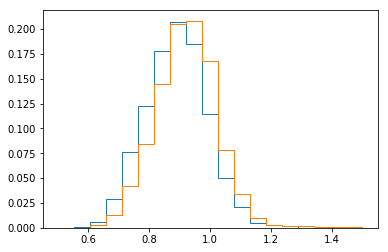

In [28]:
koi_table1=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_feh_2sigma_hot.csv',sep=',')
koi_table2=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_feh_2sigma_cool.csv',sep=',')
fig=plt.figure()
bins=np.linspace(0.5,1.5,20)
weights1 = np.ones_like(koi_table1['mass'])/float(len(koi_table1['mass']))
plt.hist(koi_table1['mass'],bins,histtype="step",weights=weights1)

weights1 = np.ones_like(koi_table2['mass'])/float(len(koi_table2['mass']))
bins=np.linspace(0.5,1.5,20)
plt.hist(koi_table2['mass'],bins,histtype="step",weights=weights1)


(array([0.        , 0.        , 0.        , 0.00031468, 0.00127971,
        0.00295802, 0.00748946, 0.02284599, 0.05597164, 0.13176831,
        0.17708268, 0.16294292, 0.12679632, 0.08316026, 0.05467095,
        0.03809764, 0.02825854, 0.02414668, 0.01957329]),
 array([0.5       , 0.55263158, 0.60526316, 0.65789474, 0.71052632,
        0.76315789, 0.81578947, 0.86842105, 0.92105263, 0.97368421,
        1.02631579, 1.07894737, 1.13157895, 1.18421053, 1.23684211,
        1.28947368, 1.34210526, 1.39473684, 1.44736842, 1.5       ]),
 <a list of 1 Patch objects>)

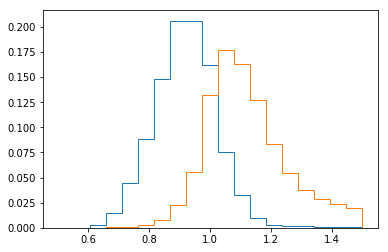

In [29]:
koi_table1=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table2=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')

fig=plt.figure()
bins=np.linspace(0.5,1.5,20)
weights1 = np.ones_like(koi_table1['mass'])/float(len(koi_table1['mass']))
plt.hist(koi_table1['mass'],bins,histtype="step",weights=weights1)

weights1 = np.ones_like(koi_table2['mass'])/float(len(koi_table2['mass']))
bins=np.linspace(0.5,1.5,20)
plt.hist(koi_table2['mass'],bins,histtype="step",weights=weights1)

(array([0.03499276, 0.03748925, 0.03474102, 0.06813938, 0.09113223,
        0.07598548, 0.14297103, 0.16086601, 0.08626513, 0.06679674,
        0.07783162, 0.01751736, 0.01176915, 0.02551031, 0.00346151,
        0.00157342, 0.00497199, 0.0007972 , 0.00071328]),
 array([-0.5       , -0.44736842, -0.39473684, -0.34210526, -0.28947368,
        -0.23684211, -0.18421053, -0.13157895, -0.07894737, -0.02631579,
         0.02631579,  0.07894737,  0.13157895,  0.18421053,  0.23684211,
         0.28947368,  0.34210526,  0.39473684,  0.44736842,  0.5       ]),
 <a list of 1 Patch objects>)

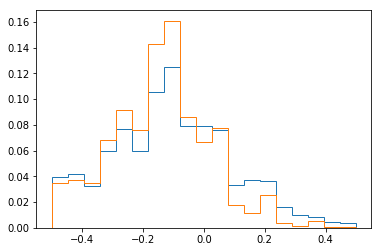

In [30]:
koi_table1=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table2=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')

fig=plt.figure()
bins=np.linspace(-0.5,0.5,20)
weights1 = np.ones_like(koi_table1['feh'])/float(len(koi_table1['feh']))
plt.hist(koi_table1['feh'],bins,histtype="step",weights=weights1)

weights1 = np.ones_like(koi_table2['feh'])/float(len(koi_table2['feh']))
bins=np.linspace(-0.5,0.5,20)
plt.hist(koi_table2['feh'],bins,histtype="step",weights=weights1)

/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in double_scalars


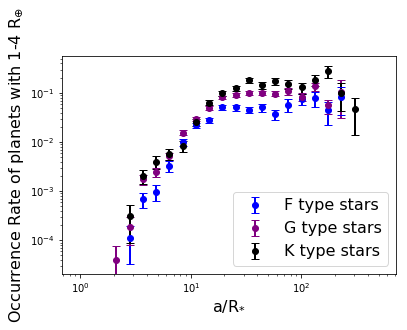

In [4]:
# a/R_* distribution for stars with different spectral type

#F type

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_stellar_q17_add_dispersions_reduction_reduction_F.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/data/kepler_koi_q17_add_dispersions_reduction_reduction_F_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)

colors=['orange','blue','purple','black']

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/F/result/occurrence_rate_F_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),25,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),25,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]

for i in range(0,len(bins_a_ratio)-1):
    focc_temp=[]
    a_ratio_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi_ratio[f_id[j]]<bins_a_ratio[i+1] and a_koi_ratio[f_id[j]]>=bins_a_ratio[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(a_ratio,f_p,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='F type stars') 


#G type

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/data/kepler_koi_q17_add_dispersions_reduction_reduction_G_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)

colors=['orange','blue','purple','black']

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/G/result/occurrence_rate_G_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),25,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),25,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]

for i in range(0,len(bins_a_ratio)-1):
    focc_temp=[]
    a_ratio_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi_ratio[f_id[j]]<bins_a_ratio[i+1] and a_koi_ratio[f_id[j]]>=bins_a_ratio[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(a_ratio,f_p,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='G type stars') 


#F type

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_stellar_q17_add_dispersions_reduction_reduction_K.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/data/kepler_koi_q17_add_dispersions_reduction_reduction_K_new.csv',sep=',')

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

bins_t=np.logspace(math.log(120,5),math.log(6000,5),25,base=5)

colors=['orange','blue','purple','black']

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/K/result/occurrence_rate_K_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),25,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),25,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]

for i in range(0,len(bins_a_ratio)-1):
    focc_temp=[]
    a_ratio_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi_ratio[f_id[j]]<bins_a_ratio[i+1] and a_koi_ratio[f_id[j]]>=bins_a_ratio[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(a_ratio,f_p,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='K type stars') 

plt.xscale('log')
plt.yscale('log')
plt.xlabel('a/R$_{*}$', fontsize=16)
plt.ylabel('Occurrence Rate of planets with 1-4 R$_{\oplus}$',fontsize=16,)
plt.legend(loc='best',fontsize=16)
plt.savefig('result/a_ratio_FGK_p365_1_4Rearth.eps')